In [1]:
import krotov
import numpy as np
import matplotlib.pyplot as plt
from qutip import *
from scipy import *

In [2]:
a = tensor(destroy(50), qeye(2))
sm = tensor(qeye(50), destroy(2))

In [8]:
def hamiltonian(omega_r = 0.5, omega_m = 0.5,ampl0=1,g=1):
    """JC

    Args:
        omega (float): energy separation of the qubit levels
        ampl0 (float): constant amplitude of the driving field
        
    """
    N1=50
    n=10
    a = tensor(destroy(N1), qeye(2))
    sm = tensor(qeye(N1), destroy(2))
    H0 = omega_r * a.dag() * a + 0.5*omega_m * (sm.dag() * sm-sm *sm.dag())
    H1 = g * (a.dag()*sm + a*sm.dag())

    def guess_control(t, args):
        return ampl0 * krotov.shapes.flattop(
            t, t_start=0, t_stop=4, t_rise=1.5, func="blackman"
        )

    return [H0, [H1, guess_control]]

In [9]:
H = hamiltonian()

In [10]:
tlist = np.linspace(0, 4, 5000)

In [11]:
def plot_pulse(pulse, tlist):
    fig, ax = plt.subplots()
    if callable(pulse):
        pulse = np.array([pulse(t, args=None) for t in tlist])
    ax.plot(tlist, pulse)
    ax.set_xlabel('time')
    ax.set_ylabel('pulse amplitude')
    plt.show(fig)

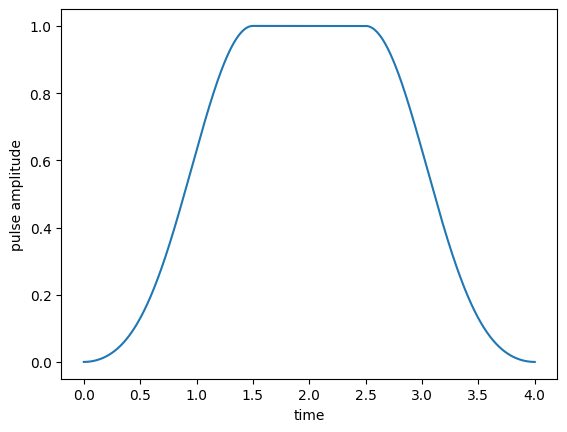

In [12]:
plot_pulse(H[1][1], tlist)

In [13]:
objectives = [
    krotov.Objective(
        initial_state= tensor(basis(50, 0), basis(2, 1)), target= tensor(basis(50, 1), basis(2, 0)), H=H
    )
]

objectives

[Objective[|Ψ₀(50⊗2)⟩ to |Ψ₁(50⊗2)⟩ via [H₀[50⊗2,50⊗2], [H₁[50⊗2,50⊗2], u₁(t)]]]]

In [15]:
def S(t):
    """Shape function for the field update"""
    return krotov.shapes.flattop(
        t, t_start=0, t_stop=np.pi*(2*10+1)/(2*1), t_rise=1.5, t_fall=1.5, func='blackman'
    )

In [16]:
pulse_options = {
    H[1][1]: dict(lambda_a=50, update_shape=S)
}

In [17]:
proj0 = sm.dag() * sm
proj1 = sm * sm.dag()
poroj3 = a.dag() * a

In [18]:
guess_dynamics = objectives[0].mesolve(tlist, e_ops=[proj0, proj1, poroj3])


In [19]:
def plot_population(result):
    fig, ax = plt.subplots()
    ax.plot(result.times, result.expect[0], label='|g>')
    ax.plot(result.times, result.expect[1], label='|e>')
    ax.plot(result.times, result.expect[2], label='número de fotones')
    ax.legend()
    ax.set_xlabel('time')
    ax.set_ylabel('population')
    plt.show(fig)

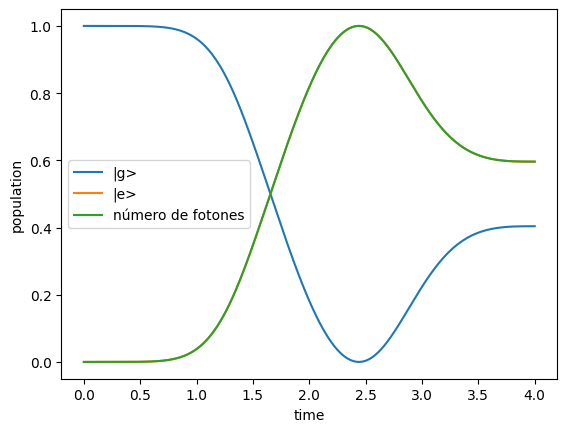

In [20]:
plot_population(guess_dynamics)

In [21]:
opt_result = krotov.optimize_pulses(
    objectives,
    pulse_options=pulse_options,
    tlist=tlist,
    propagator=krotov.propagators.expm,
    chi_constructor=krotov.functionals.chis_ss,
    info_hook=krotov.info_hooks.print_table(J_T=krotov.functionals.J_T_ss),
    check_convergence=krotov.convergence.Or(
        krotov.convergence.value_below('1e-3', name='J_T'),
        krotov.convergence.check_monotonic_error,
    ),
    store_all_pulses=True,
)

iter.      J_T    ∫gₐ(t)dt          J       ΔJ_T         ΔJ  secs
0     4.04e-01    0.00e+00   4.04e-01        n/a        n/a    23
1     3.75e-01    2.74e-04   3.75e-01  -2.94e-02  -2.91e-02    48
2     3.46e-01    2.66e-04   3.47e-01  -2.85e-02  -2.83e-02    47
3     3.19e-01    2.57e-04   3.19e-01  -2.75e-02  -2.72e-02    47
4     2.93e-01    2.46e-04   2.93e-01  -2.63e-02  -2.61e-02    47
5     2.68e-01    2.34e-04   2.68e-01  -2.50e-02  -2.48e-02    47
6     2.44e-01    2.21e-04   2.44e-01  -2.36e-02  -2.34e-02    48
7     2.22e-01    2.08e-04   2.22e-01  -2.22e-02  -2.20e-02    50
8     2.01e-01    1.94e-04   2.01e-01  -2.07e-02  -2.05e-02    48
9     1.82e-01    1.80e-04   1.82e-01  -1.93e-02  -1.91e-02    48
10    1.64e-01    1.67e-04   1.64e-01  -1.78e-02  -1.76e-02    48
11    1.48e-01    1.54e-04   1.48e-01  -1.64e-02  -1.62e-02    48
12    1.33e-01    1.41e-04   1.33e-01  -1.50e-02  -1.49e-02    48
13    1.19e-01    1.29e-04   1.19e-01  -1.37e-02  -1.36e-02    48
14    1.06

In [22]:
opt_result

Krotov Optimization Result
--------------------------
- Started at 2024-03-01 17:34:55
- Number of objectives: 1
- Number of iterations: 53
- Reason for termination: Reached convergence: J_T < 1e-3
- Ended at 2024-03-01 18:17:35 (0:42:40)

In [23]:
opt_dynamics = opt_result.optimized_objectives[0].mesolve(
    tlist, e_ops=[proj0, proj1, poroj3])

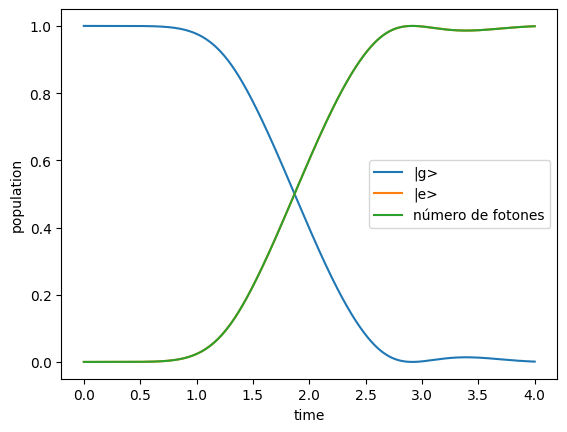

In [24]:
plot_population(opt_dynamics)

In [25]:
def plot_iterations(opt_result):
    """Plot the control fields in population dynamics over all iterations.

    This depends on ``store_all_pulses=True`` in the call to
    `optimize_pulses`.
    """
    fig, [ax_ctr, ax_dyn] = plt.subplots(nrows=2, figsize=(10, 12))
    n_iters = len(opt_result.iters)
    for (iteration, pulses) in zip(opt_result.iters, opt_result.all_pulses):
        controls = [
            krotov.conversions.pulse_onto_tlist(pulse)
            for pulse in pulses
        ]
        objectives = opt_result.objectives_with_controls(controls)
        dynamics = objectives[0].mesolve(
            opt_result.tlist, e_ops=[proj0, proj1, poroj3]
        )
        if iteration == 0:
            ls = '--'  # dashed
            alpha = 1  # full opacity
            ctr_label = 'guess'
            pop_labels = ['0 (guess)', '1 (guess)', 'número de fotones']
        elif iteration == opt_result.iters[-1]:
            ls = '-'  # solid
            alpha = 1  # full opacity
            ctr_label = 'optimized'
            pop_labels = ['0 (optimized)', '1 (optimized)', 'número de fotones']
        else:
            ls = '-'  # solid
            alpha = 0.5 * float(iteration) / float(n_iters)  # max 50%
            ctr_label = None
            pop_labels = [None, None, None]
        ax_ctr.plot(
            dynamics.times,
            controls[0],
            label=ctr_label,
            color='black',
            ls=ls,
            alpha=alpha,
        )
        ax_dyn.plot(
            dynamics.times,
            dynamics.expect[0],
            label=pop_labels[0],
            color='#1f77b4',  # default blue
            ls=ls,
            alpha=alpha,
        )
        ax_dyn.plot(
            dynamics.times,
            dynamics.expect[1],
            label=pop_labels[1],
            color='#ff7f0e',  # default orange
            ls=ls,
            alpha=alpha,
        )
        ax_dyn.plot(
            dynamics.times,
            dynamics.expect[2],
            label=pop_labels[2],
            color='#2ca02c',  # default green
            ls=ls,
            alpha=alpha,
        )



        



    ax_dyn.legend()
    ax_dyn.set_xlabel('time', fontsize=14)
    ax_dyn.set_ylabel('population', fontsize=14)
    ax_ctr.legend()
    ax_ctr.set_xlabel('time')
    ax_ctr.set_ylabel('control amplitude')
    plt.show(fig)

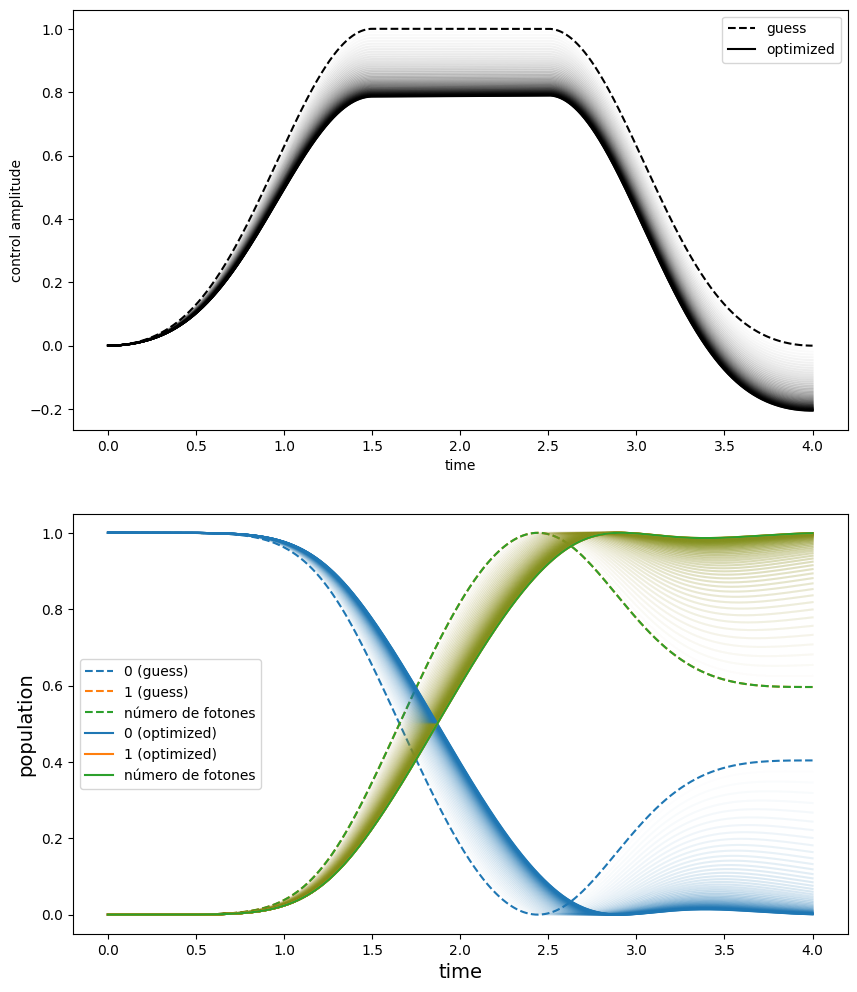

In [26]:
plot_iterations(opt_result)

In [70]:
#Repitamos lo anterior para un Hamiltoniano netamente fotónico

def hamiltonian(omega_r = 0.5, omega_m = 0.5,ampl0=1,g=1):
    """JC

    Args:
        omega (float): energy separation of the qubit levels
        ampl0 (float): constant amplitude of the driving field
        
    """
    N1=50
    n=10
    a = destroy(50)
    ad = create(50)
    H0 = omega_r * ad * a 
    H1 = a+ad

    def guess_control(t, args):
        return ampl0 * krotov.shapes.flattop(
            t, t_start=0, t_stop=np.pi*(2*n+1)/(2*g), t_rise=10, func="blackman"
        )

    return [H0, [H1, guess_control]]

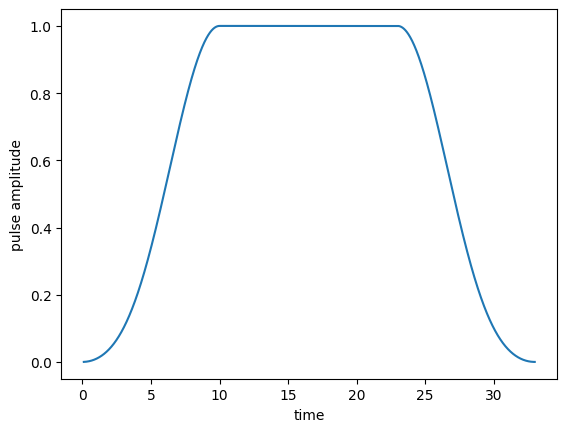

In [71]:

H = hamiltonian()

tlist = np.linspace(0.1, np.pi*(2*10+1)/(2*1), 5000)

def plot_pulse(pulse, tlist):
    fig, ax = plt.subplots()
    if callable(pulse):
        pulse = np.array([pulse(t, args=None) for t in tlist])
    ax.plot(tlist, pulse)
    ax.set_xlabel('time')
    ax.set_ylabel('pulse amplitude')
    plt.show(fig)

plot_pulse(H[1][1], tlist)


In [72]:

objectives = [ krotov.Objective( initial_state= basis(50, 0), target= basis(50, 10), H=H ) ]

objectives

[Objective[|Ψ₁₄(50)⟩ to |Ψ₁₅(50)⟩ via [H₈[50,50], [H₉[50,50], u₅(t)]]]]

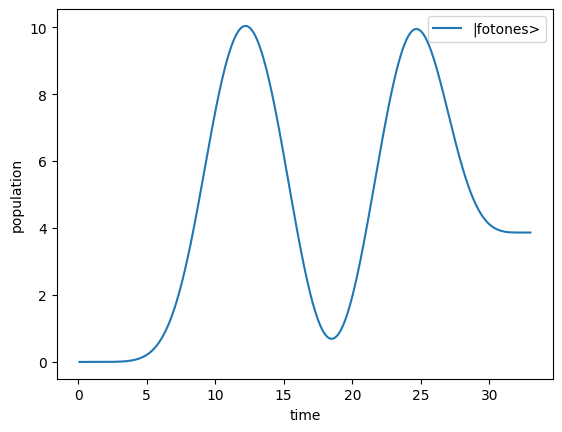

In [73]:
a = destroy(50)
ad = create(50)


def S(t):
    """Shape function for the field update"""
    return krotov.shapes.flattop(
        t, t_start=0, t_stop=np.pi*(2*10+1)/(2*1), t_rise=3, t_fall=3, func='blackman'
    )

pulse_options = {
    H[1][1]: dict(lambda_a=50, update_shape=S)
}

proj0 = ad * a

guess_dynamics = objectives[0].mesolve(tlist, e_ops=[proj0])


def plot_population(result):
    fig, ax = plt.subplots()
    ax.plot(result.times, result.expect[0], label='|fotones>')
    ax.legend()
    ax.set_xlabel('time')
    ax.set_ylabel('population')
    plt.show(fig)

plot_population(guess_dynamics)



In [74]:

opt_result = krotov.optimize_pulses( 
    objectives,
    pulse_options=pulse_options,
    tlist=tlist,
    propagator=krotov.propagators.expm,
    chi_constructor=krotov.functionals.chis_ss,
    info_hook=krotov.info_hooks.print_table(J_T=krotov.functionals.J_T_ss),
    check_convergence=krotov.convergence.Or(
        krotov.convergence.value_below('1e-3', name='J_T'),
        krotov.convergence.check_monotonic_error,
    ),
    store_all_pulses=True,
)

opt_result

iter.      J_T    ∫gₐ(t)dt          J       ΔJ_T         ΔJ  secs
0     9.96e-01    0.00e+00   9.96e-01        n/a        n/a    14
1     9.96e-01    1.11e-06   9.96e-01  -1.13e-04  -1.12e-04    31
2     9.95e-01    1.15e-06   9.95e-01  -1.18e-04  -1.16e-04    30
3     9.95e-01    1.20e-06   9.95e-01  -1.23e-04  -1.21e-04    30
4     9.95e-01    1.26e-06   9.95e-01  -1.28e-04  -1.27e-04    31
5     9.95e-01    1.31e-06   9.95e-01  -1.34e-04  -1.33e-04    31
6     9.95e-01    1.37e-06   9.95e-01  -1.40e-04  -1.39e-04    31
7     9.95e-01    1.44e-06   9.95e-01  -1.47e-04  -1.45e-04    31
8     9.95e-01    1.51e-06   9.95e-01  -1.54e-04  -1.52e-04    32
9     9.94e-01    1.58e-06   9.94e-01  -1.61e-04  -1.59e-04    31
10    9.94e-01    1.66e-06   9.94e-01  -1.69e-04  -1.67e-04    30
11    9.94e-01    1.74e-06   9.94e-01  -1.77e-04  -1.76e-04    30
12    9.94e-01    1.83e-06   9.94e-01  -1.86e-04  -1.84e-04    31
13    9.94e-01    1.92e-06   9.94e-01  -1.96e-04  -1.94e-04    31
14    9.94

Krotov Optimization Result
--------------------------
- Started at 2024-03-01 15:01:26
- Number of objectives: 1
- Number of iterations: 221
- Reason for termination: Reached convergence: Loss of monotonic convergence; error decrease < 0
- Ended at 2024-03-01 16:53:03 (1:51:37)